Tutorial 5: Borders
===================

In the previous tutorials, the source-plane pixel grid perfectly mapped over the traced image-pixel $(y,x)$ coordinates
in the source plane. If these pixels mapped to a larger area in the source plane, its pixel-grid would automatically
increase its size so as to cover every source-plane coordinate.

In this tutorial, we will consider how the size of the pixelization grid is chosen and introduce the concept of a
border.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllSersic`.

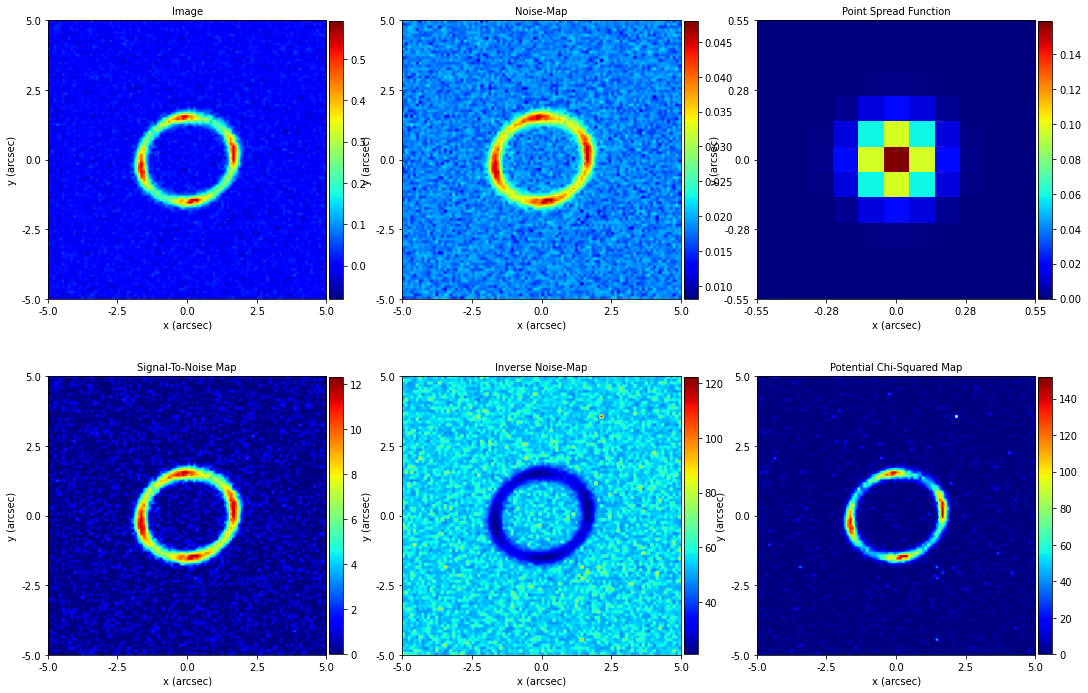

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Borders__

So, what is a border? In the image-plane, a border is the set of exterior pixels in a mask that are at its border.

Lets plot the image with a circular circular and tell our `ImagingPlotter` to plot the border.

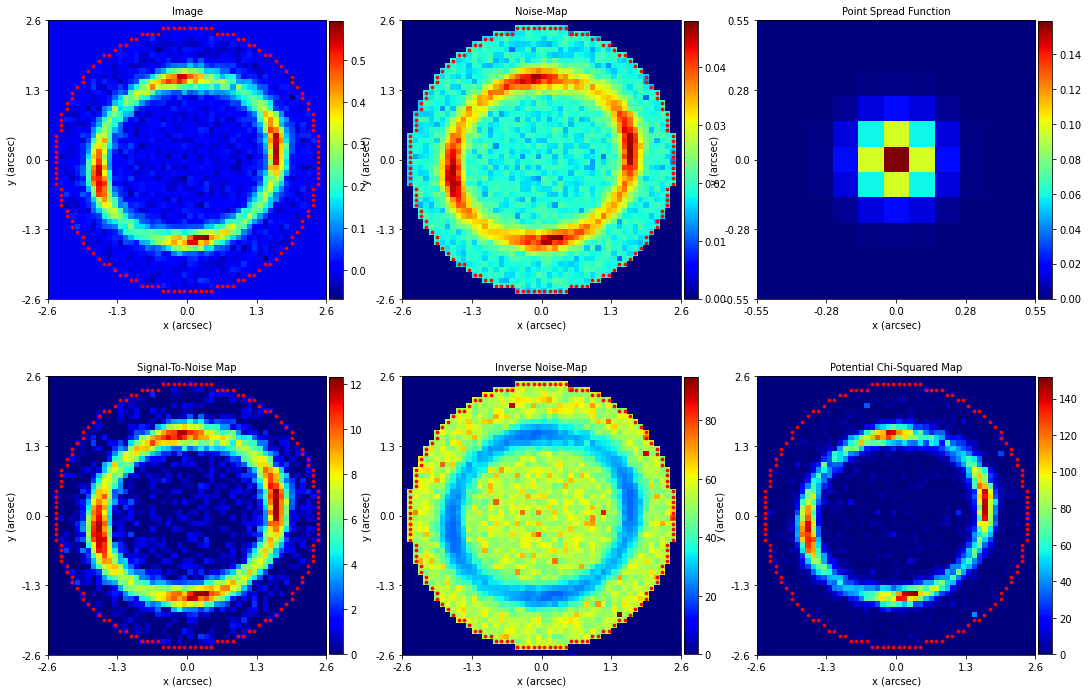

In [3]:
mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.5,
)
imaging = imaging.apply_mask(mask=mask_circular)

include_2d = aplt.Include2D(border=True)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, include_2d=include_2d)
imaging_plotter.subplot_imaging()

As you can see, for a circular mask the border *is* the edge of the mask (the ring of black dots we're used to 
seeing whenever we plot a mask. 

For an annular mask, pixels on its inner edge are not a part of the border, whereas those on its outer edge are.

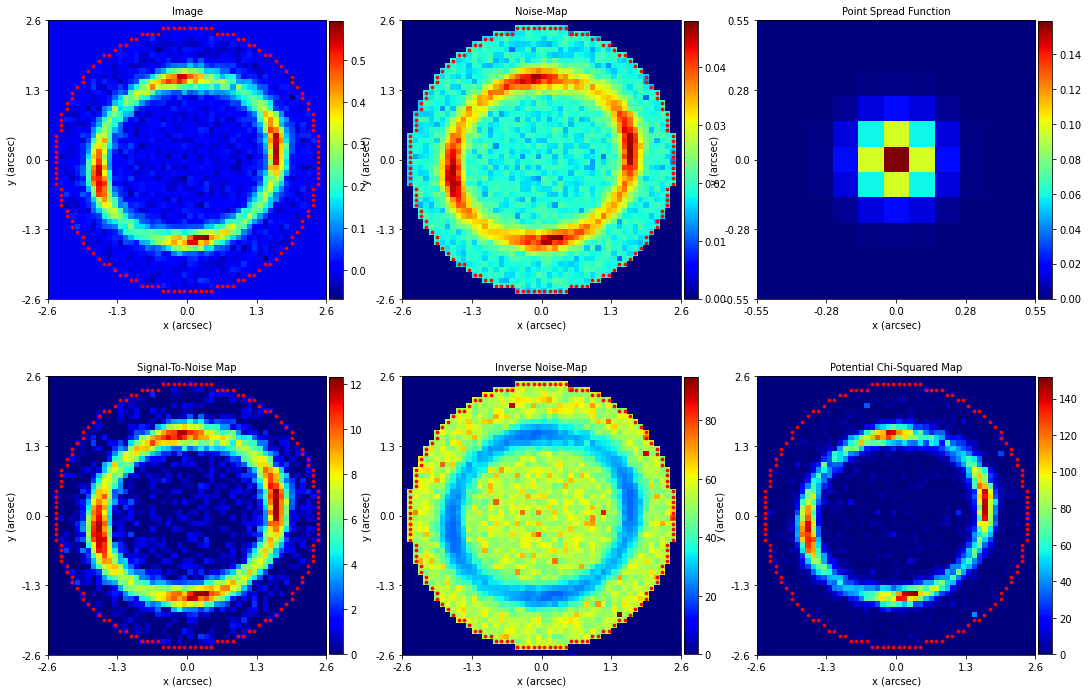

In [4]:
mask_annular = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    inner_radius=0.8,
    outer_radius=2.5,
)

imaging = imaging.apply_mask(mask=mask_circular)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, include_2d=include_2d)
imaging_plotter.subplot_imaging()

A border is therefore *only* the pixels at the exterior edge of a mask

So, what does a border actually do? To show you, we'll need to fit this image with a lens model and inversion. We'll 
use the same convenience function we used in the previous tutorial (to perform a quick source galaxy fit) with the 
options to input a mask and use a border.

In [5]:


def perform_fit_with_source_galaxy_mask_and_border(
    imaging, source_galaxy, mask, settings_pixelization
):

    imaging = imaging.apply_mask(mask=mask)

    lens_galaxy = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllIsothermal(
            centre=(0.0, 0.0),
            einstein_radius=1.6,
            elliptical_comps=al.convert.elliptical_comps_from(
                axis_ratio=0.9, angle=45.0
            ),
        ),
        shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(
        imaging=imaging, tracer=tracer, settings_pixelization=settings_pixelization
    )


Okay, so lets first look at the mapper without using a border and using annular mask.

First, note how we set up the border, using a `SettingsPixelization` object. This behaves analogously to the 
`SettingsImaging` and `SettingsLens` objects we have used in previous tutorials.

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 675:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


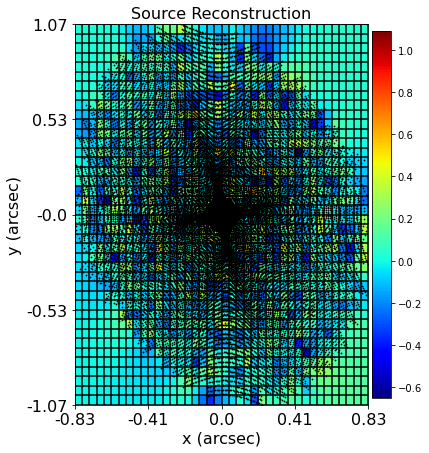

In [6]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

fit = perform_fit_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_annular,
    settings_pixelization=al.SettingsPixelization(use_border=False),
)

include_2d = aplt.Include2D(mapper_source_grid_slim=True)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

Everything looks fine, we get a reconstructed source on a visually appeasing source-plane grid. So, why are we so 
worried about borders? Lets see what happens if we use a circular mask instead.

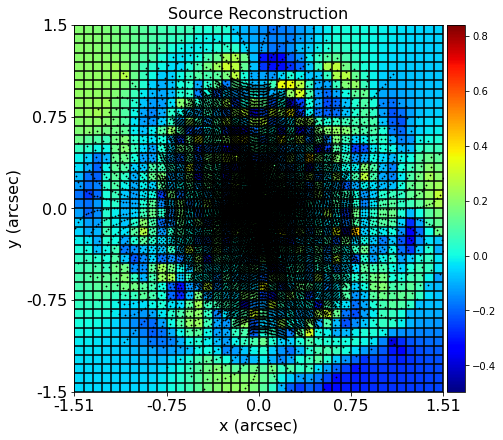

In [7]:
fit = perform_fit_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=False),
)

inversion_plotter = aplt.InversionPlotter(
    inversion=fit.inversion, include_2d=include_2d
)
inversion_plotter.figures_2d(reconstruction=True)

Woah, whats happened? There are lots of additional $(y,x)$ coordinates in the source-plane grid, some of which trace 
to extremely large radii far away from the central regions of the source-plane! These points are the traced image-pixels 
that correspond to the central image-pixels that the annular mask removed (e.g. they were at radii with 0.8" of the 
centre).

Lets quickly check this by plotting the indexes of these image-pixels.

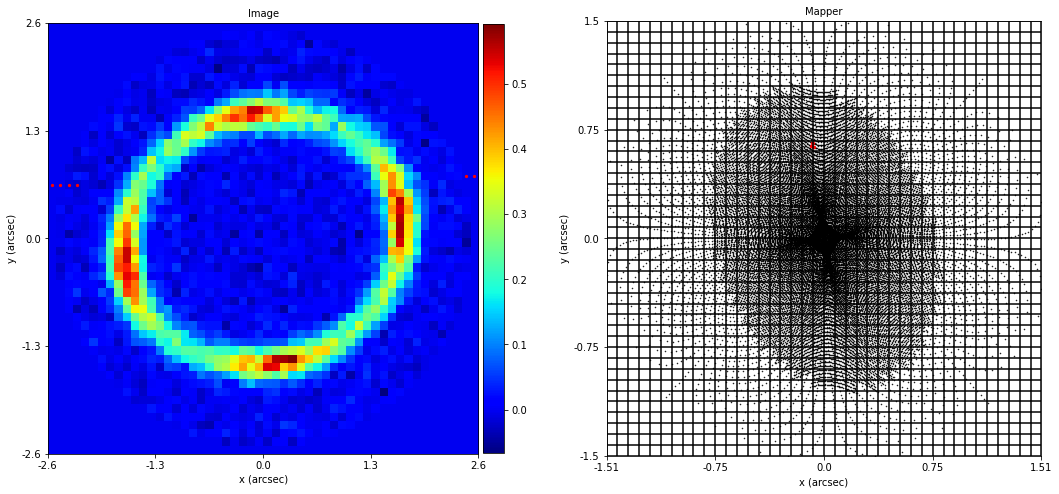

In [8]:
visuals_2d = aplt.Visuals2D(indexes=[986, 987, 988, 989, 990, 991])
include_2d = aplt.Include2D(mapper_source_grid_slim=True)

mapper_plotter = aplt.MapperPlotter(
    mapper=fit.inversion.mapper, visuals_2d=visuals_2d, include_2d=include_2d
)

mapper_plotter.subplot_image_and_mapper(image=fit.imaging.image)

So, why is this happening? What is the mass profile physically doing to create these source plane coordinates at 
extremely large radial values? 

Towards the centre of th elliptical isothermal mass profile, the density begins to rise very sharply, it becomes 
extremely steep or 'cuspy'. This cuspy behaviour towards its centre can cause extremely large deflection angles to be 
calculated:

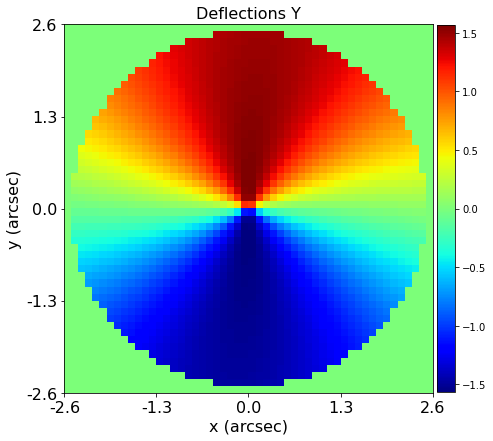

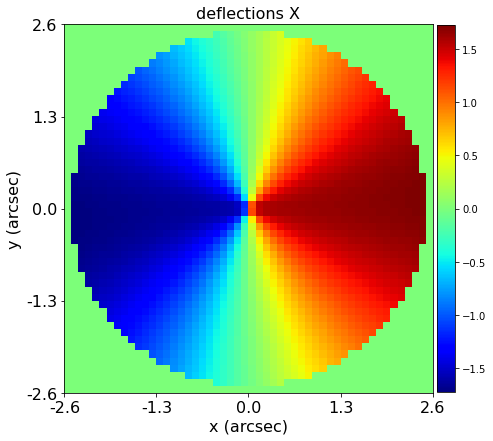

In [9]:
tracer_plotter = aplt.TracerPlotter(tracer=fit.tracer, grid=fit.grid)
tracer_plotter.figures_2d(deflections_y=True, deflections_x=True)

Central image pixel can therefore be subjected to 'demagnification', whereby they trace to extremely large values in 
the source plane! 

Physically, this is not a problem, and it is the reason we do not see a 'central image' in most strong lenses, as the 
light-rays which take this path through the centre of the lens are demagnified. However, if the lens galaxy had a less
steep inner mass distribution (termed a 'core') we would see the central image.

Demagnification is a problem for the pixelization and inversion though, which reconstruct the flux of these 
demagnified pixels just like the other pixels in the image-pixel. There are two negative consequences:

 1) The rectangular pixel-grid that we 'lay over' the source-plane is very larger because it expands to include the 
 demagnified image-pixels. As a result, larger source-pixels are used to reconstruct the central regions of the 
 source-plane (where the source galaxy is actually located), meaning we reconstruct the source-galaxy at a lower 
 effective resolution.
    
 2) The inversion reconstructs the flux of the demanigified image pixels using source-pixels which contain *only* 
 demagnified image pixels (these are the source pixels at the edge of the source plane). These source-pixels *should* 
 have had other image-pixels traced within them via image-pixels at even larger radii from the centre of the lens 
 galaxy. However, these image-pixels are at radii above 3.0", meaning the circular mask removed them from the inversion.

Lets quickly use a large circular mask to confirm that these pixels exist when we don't mask them.

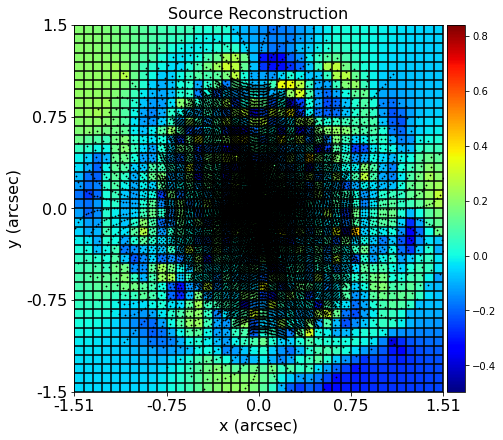

In [10]:
mask_circular_large = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=4.0
)

fit = perform_fit_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=False),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

This second point is a *huge* problem and it can introduce extremely dangerous systematics into our source 
reconstruction and lens models. 

Borders are the solution to this problem. We simply take the mask's` border in the image-plane that we showed above, 
trace it to the source-plane and relocate all traced image-pixels pixels outside this source-plane border to its edge. 
Lets take a look:

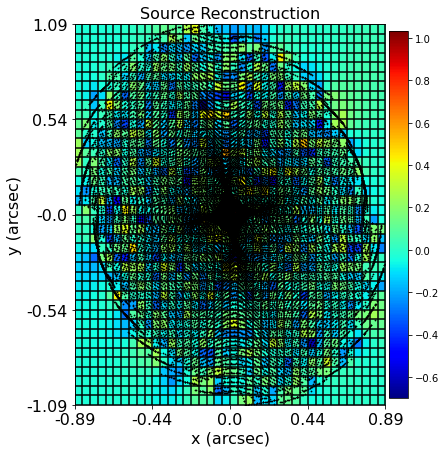

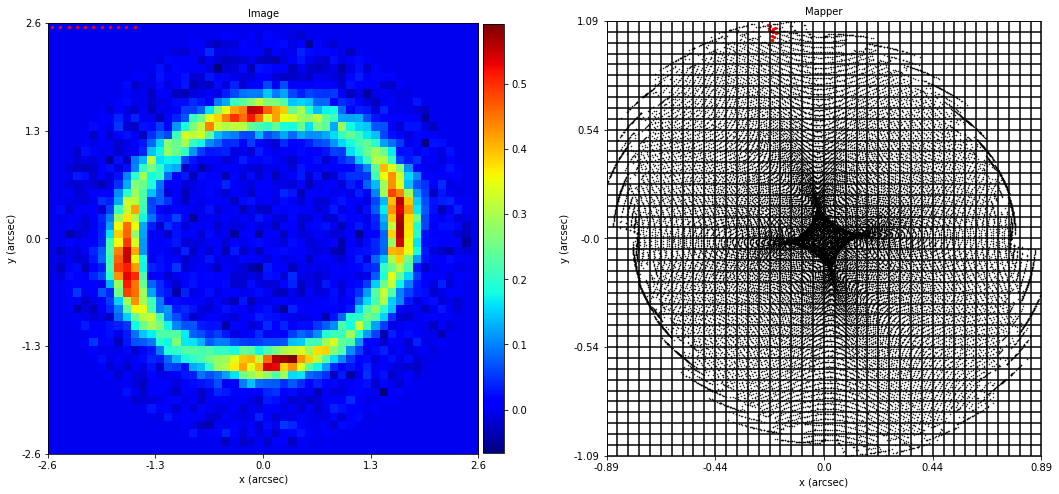

In [11]:
fit = perform_fit_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

visuals_2d = aplt.Visuals2D(indexes=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])

mapper_plotter = aplt.MapperPlotter(
    mapper=fit.inversion.mapper, visuals_2d=visuals_2d, include_2d=include_2d
)
mapper_plotter.subplot_image_and_mapper(image=fit.imaging.image)

This successfully addresses both of the issues above! However, you might be thinking, isn't that a bit of a hack? Its 
not really a physical treatment of the ray-tracing, is it?

Well, you are right. However, the *only* physical way to do this would be to use a mask so large that all demangified 
central pixels are surrounded by traced image-pixels. This would require a mask so large the **PyAutoLens** fit would
become extremely slow. This is not a feasible solution, thus borders provide us with a workaround, one that is 
extensively tested and does not introduce systematic biases into the lens modeling procedure.

To end, lets illustrate how important borders are when modeling multiple lens galaxies. Their complex mass distribution 
and lensing configurations produce nasty edge effects where image pixels not just in the centre of mask, but anywhere 
in the mask, trace beyond the source-plane border.

we'll use new strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - There are two lens galaxies whose `MassProfile`'s are `EllIsothermal`.
 - The source galaxy's `LightProfile` is an `EllSersic`.

In [12]:
dataset_name = "mass_sie_x2__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.05,
)

We again must define a mask around this image, lets start with a 2.8" mask. we'll use larger masks to illustrate the
effects of the border in a moment.

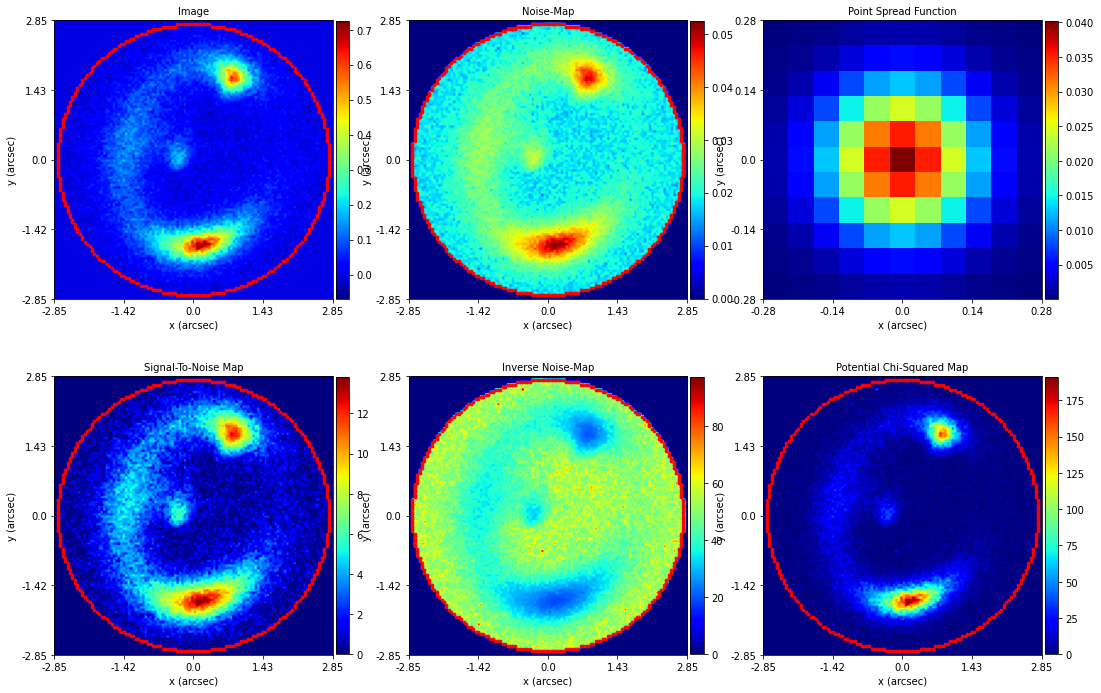

In [13]:
mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.8,
)

imaging = imaging.apply_mask(mask=mask_circular)

include_2d = aplt.Include2D(border=True)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, include_2d=include_2d)
imaging_plotter.subplot_imaging()

We need to redefine our perform fit function, to use the x2 lens galaxy model.

In [14]:


def perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging, source_galaxy, mask, settings_pixelization
):

    imaging = imaging.apply_mask(mask=mask)

    lens_galaxy_0 = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllIsothermal(
            centre=(1.1, 0.51), elliptical_comps=(0.0, 0.15), einstein_radius=1.07
        ),
    )

    lens_galaxy_1 = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllIsothermal(
            centre=(-0.20, -0.35), elliptical_comps=(0.06, 0.1053), einstein_radius=0.71
        ),
    )

    tracer = al.Tracer.from_galaxies(
        galaxies=[lens_galaxy_0, lens_galaxy_1, source_galaxy]
    )

    return al.FitImaging(
        imaging=imaging, tracer=tracer, settings_pixelization=settings_pixelization
    )


Now, lets fit this image using the input model and perform the source reconstruction without a border. As you can see, 
we get many demagnified image pixels which trace well beyond our source-plane border if we don't relocate them!

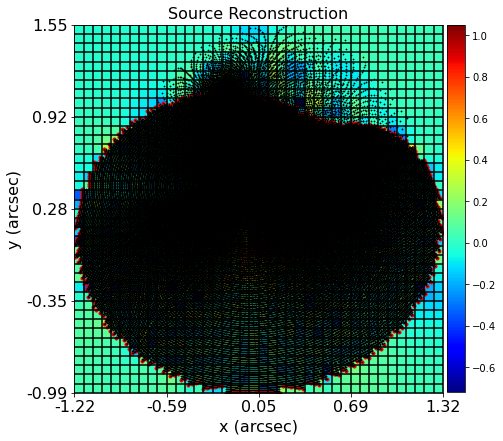

In [15]:
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=False),
)

include_2d = aplt.Include2D(mapper_source_grid_slim=True, border=True)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

However, when we relocate them, we get a good-looking source-plane with a well defined border and edge, thus ensuring 
our analysis will be free of systematic biases.

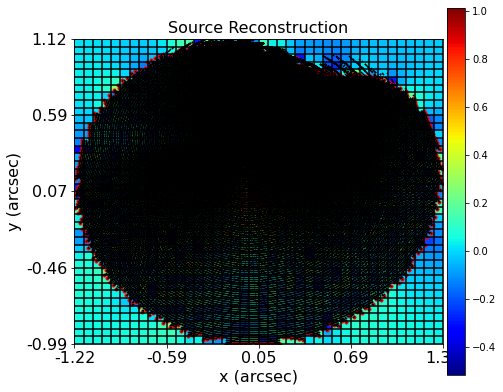

In [16]:
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

Multi-galaxy modeling is rife for border effects and if you have multiple lens galaxies I heartily recommend you pay 
a close eye to your source-plane borders!

Care must also be taken when choosing the size of your mask. If you don't choose a big enough mask, the border won't 
be able to relocate all of the demanigified image pixels to the border edge.

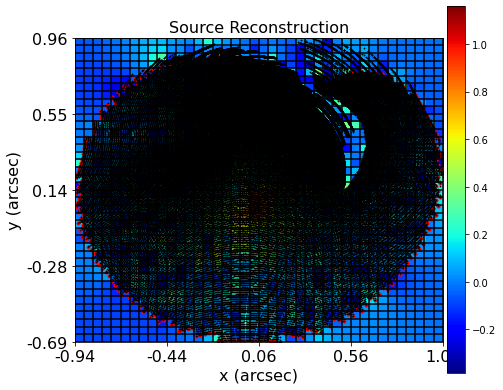

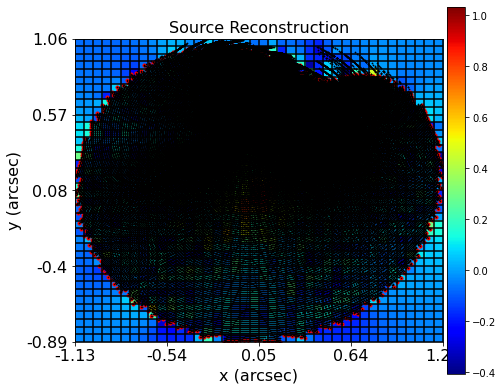

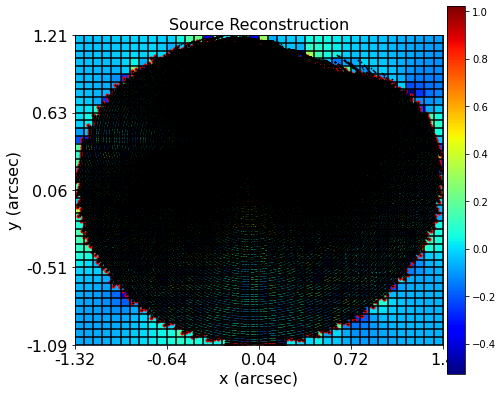

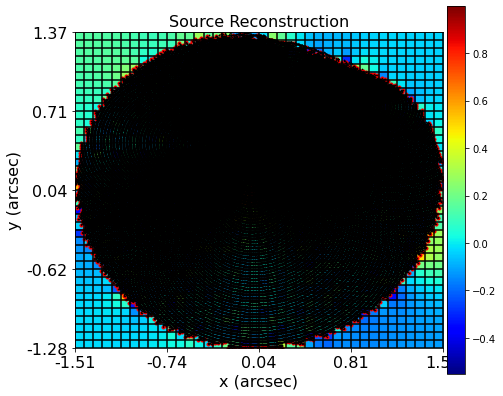

In [17]:
mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.5,
)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.7,
)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)


mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.9,
)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)


mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=3.1,
)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

__Wrap Up__

When using **PyAutoLens** to perform inversions, you probably won't think about borders all that often. Borders should 
pretty much take care of themselves.

However, as I showed above, if you don't choose a large enough mask things can go wrong and its important you know what 
borders are, so you can diagnose this potential source of systematics!